here I use a guide from https://course.fast.ai/ 

# Image-Classification

In [5]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [6]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

# 1 Download images of bicycle, bus or train 

In [14]:
# if this code does give an error-message then just run it a second time 

# from duckduckgo_search import ddg_images
from fastcore.all import *

#def search_images(term, max_images=30):
#    print(f"Searching for '{term}'")
#    return L(ddg_images(term, max_results=max_images)).itemgot('image')


#Quelle: https://forums.fast.ai/t/duckduckgo-search-not-working/105738/39?page=2
from duckduckgo_search import DDGS
def search_images(term, max_images=200):
    with DDGS(headers = {"Accept-Encoding": "gzip, deflate, br"}) as ddgs:
        results = ddgs.images(keywords=term)[0:max_images]  #ist kein iterator - das ist rin problem
        images = [res.get("image") for res in results] 
        return L(images)


### 1.1 Beispiel-Bilder

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [9]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bus', max_images=1)
urls[0]

'http://upload.wikimedia.org/wikipedia/commons/2/2f/Bangalore_Metropolitan_Transport_Corporation_Volvo_B7RLE_bus,_India.jpg'

...and then download a URL and take a look at it:

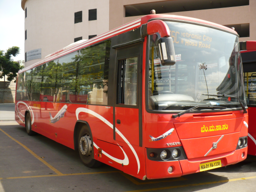

In [17]:
from fastdownload import download_url
dest = 'Bsp_bus.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

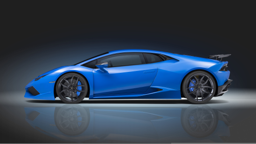

In [54]:
download_url(search_images('Auto blau', max_images=1)[0], 'Bsp_car_2.jpg', show_progress=False)
Image.open('Bsp_car_2.jpg').to_thumb(256,256)

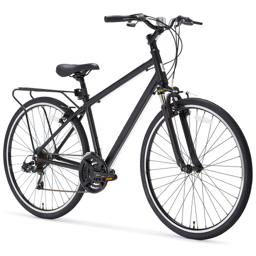

In [40]:
download_url(search_images('bicycle', max_images=1)[0], 'Bsp_bicycle.jpg', show_progress=False)
Image.open('Bsp_bicycle.jpg').to_thumb(256,256)

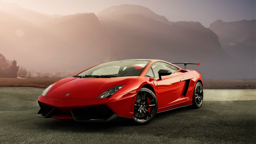

In [42]:
download_url(search_images('car', max_images=1)[0], 'Bsp_auto.jpg', show_progress=False)
Image.open('Bsp_auto.jpg').to_thumb(256,256)

## 1.2 Bilder downloaden fürs Model-trainieren

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [8]:
#searches = 'Stadtbus','train'
#path = Path('bird_or_forest')
from time import sleep

#for o in searches:
#    dest = (path/o)
#    dest.mkdir(exist_ok=True, parents=True)
#    download_images(dest, urls=search_images(f'{o} photo'))
#    sleep(10)  # Pause between searches to avoid over-loading server
#    download_images(dest, urls=search_images(f'{o} sun photo'))
#    sleep(10)
#    download_images(dest, urls=search_images(f'{o} shade photo'))
#    sleep(10)
#    resize_images(path/o, max_size=400, dest=path/o) #resize so it is much faster

In [9]:
searches = 'bus','car','bicycle'
path = Path('bus_or_train')
from time import sleep

for o in ['bus']:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} Bus Verkehr'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} Stadtbus'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} Bus wiener linien'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o) #resize so it is much faster


for o in ['car']:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} Auto kaufen'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} Auto'))
    sleep(10)
#    download_images(dest, urls=search_images(f'{o} Bus wiener linien'))
#    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o) #resize so it is much faster

In [27]:
for o in ['bicycle']:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} bicycle'))
#    sleep(10)  # Pause between searches to avoid over-loading server
#    download_images(dest, urls=search_images(f'{o} Stadtbus'))
#    sleep(10)
#    download_images(dest, urls=search_images(f'{o} Bus wiener linien'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o) #resize so it is much faster


# 2. Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [21]:
#we delete the pictures that are brocken. 
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed) 

NameError: name 'path' is not defined

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

In [20]:
#DataBlock: question how to get this data in my model. 
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #what kind of input do we have
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

NameError: name 'path' is not defined

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

### train the model

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [31]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.063416,0.025514,0.009804,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.105349,0.018150,0.000000,00:03
1,0.064861,0.004259,0.000000,00:03
2,0.045207,0.003112,0.000000,00:03


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

# 3. predictions

In [46]:
this_is,_,probs = learn.predict(PILImage.create('Bsp_bicycle.jpg'))
print(f"This is a: {this_is}.")
print(f"Probability it's a bicycle: {probs[0]:.4f}") #probs[0] steht für Fahrrad

This is a: bicycle.
Probability it's a bicycle: 1.0000


In [58]:
this_is,_,probs = learn.predict(PILImage.create('Bsp_car_2.jpg'))
print(f"This is a: {this_is}.")
print(f"Probability it's a car: {probs[2]:.4f}")  #probs[2] steht für Auto

This is a: car.
Probability it's a car: 1.0000


In [59]:
this_is,_,probs = learn.predict(PILImage.create('Bsp_bus.jpg'))
print(f"This is a: {this_is}.")
print(f"Probability it's a bus: {probs[1]:.4f}") #probs[1] steht für Bus

This is a: bus.
Probability it's a bus: 0.9993


In [60]:
this_is,_,probs = learn.predict(PILImage.create('Bsp_feet.jpg'))
print(f"This is a: {this_is}.")
print("with all Probability:",probs)

This is a: car.
with all Probability: tensor([1.6419e-01, 2.9918e-06, 8.3580e-01])


In [3]:
# funktion um Vorhersagen im Dictonary-Format zu bekommen 
categories = ('bicycle','bus','car')

def classify_dict_image(img):
    prediction,_,probability = learn.predict(img)
    return dict(zip(categories,map(float,probability)))




In [ ]:
# ich habe das selbst geschrieben - weiß aber noch nicht ob es funktioniert. das muss ich noch testen. gegebenfalls sind hier fehler drinnen

def vorhersage(imgage):
    prediction,_,probs = learn.predict(imgage)

    if prediction == 'bicycle':
        probability = probs[0]
    elif prediction == 'bus':
        probability = probs[1]
    else:  #prediction == 'car'
        probability = probs[2]

    return prediction, probability


In [18]:
foto = PILImage.create('Bsp_bus.jpg')
this_is,_,probs = learn.predict(foto)
print(f"This is a: {this_is}.")
print(f"Probability it's a bus: {probs[1]:.4f}") #probs[1] steht für Bus

NameError: name 'learn' is not defined

In [19]:
img = PILImage.create('Bsp_feet.jpg')
classify_dict_image(img)

NameError: name 'learn' is not defined

# 4. export model in pkl-file

In [61]:
#export the model
learn.export('model_image-classifier.pkl')

---

---

---

---

---

---